# Develop a robust machine learning model to accurately predict fraudulent transactions.



# Fraud Detection


# Import Libraries  

We start by importing the necessary Python libraries:  
- **Pandas & NumPy** → for data manipulation and numerical operations  
- **Matplotlib & Seaborn** → for data visualization  
- **Scikit-learn** → for preprocessing, model training, evaluation, and pipelines  
- **Imbalanced-learn (SMOTE)** → for handling class imbalance by generating synthetic minority samples  


In [4]:
#  Import Libraries
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE   # <--- NEW (for imbalance handling)


# Filtered the Warnings

In [33]:
import warnings
warnings.filterwarnings("ignore") 
sns.set(style="whitegrid")  


# Loading the dataset

In [5]:
# ================================
# 2. Load Dataset
# ================================
df = pd.read_csv('Fraud_Analysis_Dataset(in).csv')

### Feature Engineering  

In this step, we create additional features and handle data skewness:  
- **Log Transformation (`log_amount`)** → reduces skewness in the transaction amount.  
- **Winsorization (`amount_winsor`)** → caps extreme outliers in the amount feature.  
- **Balance Difference Features** →  
  - `balanceDiffOrig`: difference between old and new balance of the origin account.  
  - `balanceDiffDest`: difference between new and old balance of the destination account.  
- **Drop Irrelevant Features** → removed the `step` column, as it does not add predictive value.  


In [6]:
# ================================
# 3. Feature Engineering
# ================================
# Handle skewed 'amount'
df["log_amount"] = np.log1p(df["amount"])

# Winsorization (optional: outlier handling)
from scipy.stats.mstats import winsorize
df["amount_winsor"] = winsorize(df["amount"], limits=[0.01, 0.01])

# Create balance difference features
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Drop irrelevant features
if "step" in df.columns:
    df.drop(columns="step", inplace=True)

In [35]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,log_amount,amount_winsor,balanceDiffOrig,balanceDiffDest
0,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,5.204007,187.48,181.0,0.0
1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,5.204007,187.48,181.0,-21182.0
2,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,7.939872,2806.00,2806.0,0.0
3,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,7.939872,2806.00,2806.0,-26202.0
4,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,9.909917,20128.00,20128.0,0.0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             11142 non-null  object 
 1   amount           11142 non-null  float64
 2   nameOrig         11142 non-null  object 
 3   oldbalanceOrg    11142 non-null  float64
 4   newbalanceOrig   11142 non-null  float64
 5   nameDest         11142 non-null  object 
 6   oldbalanceDest   11142 non-null  float64
 7   newbalanceDest   11142 non-null  float64
 8   isFraud          11142 non-null  int64  
 9   log_amount       11142 non-null  float64
 10  amount_winsor    11142 non-null  float64
 11  balanceDiffOrig  11142 non-null  float64
 12  balanceDiffDest  11142 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.1+ MB


In [37]:
df.columns

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'log_amount',
       'amount_winsor', 'balanceDiffOrig', 'balanceDiffDest'],
      dtype='object')

In [38]:
df["isFraud"].value_counts()

isFraud
0    10000
1     1142
Name: count, dtype: int64

In [39]:
df.isnull().sum()

type               0
amount             0
nameOrig           0
oldbalanceOrg      0
newbalanceOrig     0
nameDest           0
oldbalanceDest     0
newbalanceDest     0
isFraud            0
log_amount         0
amount_winsor      0
balanceDiffOrig    0
balanceDiffDest    0
dtype: int64

In [40]:
df.shape

(11142, 13)

In [41]:
df.shape[0]

11142

In [42]:
round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100,2)

10.25

###  Exploratory Data Analysis (EDA)  

We explore the dataset to understand feature distributions and relationships:  
- **Pairplot** → Visualizes interactions between key features (`amount`, `log_amount`, `balanceDiffOrig`, `balanceDiffDest`) colored by fraud status.  
- **Transaction Amount Distribution** → Applied log transformation to show skewed transaction amounts more clearly.  
- **Correlation Heatmap** → Displays relationships among numeric features and their correlation with fraud.  
- **Transaction Type Distribution** → Bar chart showing frequency of each transaction type.  


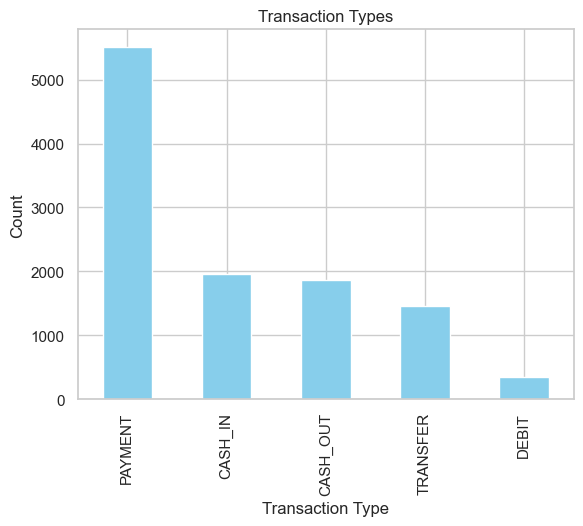

In [43]:
df["type"].value_counts().plot(kind="bar",title="Transaction Types",color="skyblue")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

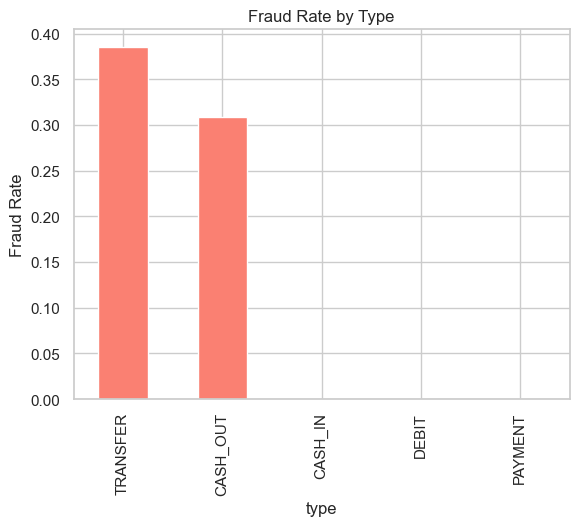

In [44]:
fraud_by_type=df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind="bar",title="Fraud Rate by Type",color="salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [45]:
fraud_by_type

type
TRANSFER    0.385246
CASH_OUT    0.308926
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [46]:
df["amount"].describe().astype(int)

count       11142
mean       213191
std        760065
min             2
25%          4946
50%         16761
75%        154336
max      10000000
Name: amount, dtype: int64

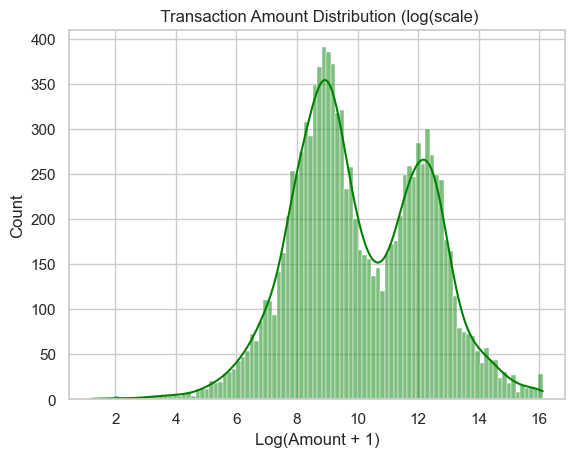

In [47]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde=True, color="green")
plt.title(" Transaction Amount Distribution (log(scale)")
plt.xlabel("Log(Amount + 1)")
plt.show()
          

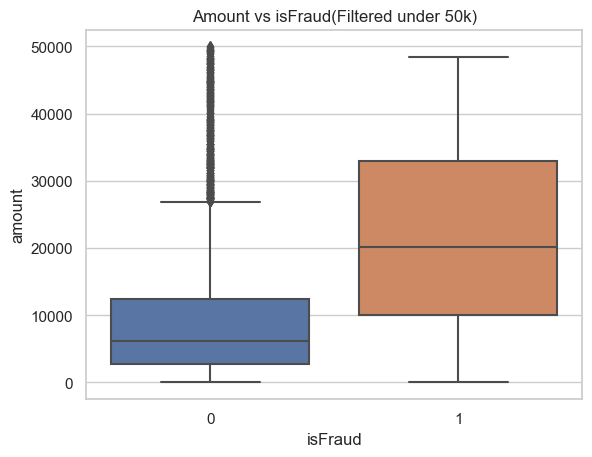

In [48]:
sns.boxplot(data=df[df["amount"] < 50000], x="isFraud",y="amount")
plt.title("Amount vs isFraud(Filtered under 50k)")
plt.show()

In [50]:
top_senders = df["nameOrig"].value_counts().head(10)

In [51]:
top_senders

nameOrig
C1305486145    1
C479078480     1
C1602363550    1
C1365013293    1
C1525186016    1
C1364051444    1
C2049210129    1
C1225830367    1
C1984803180    1
C1170952967    1
Name: count, dtype: int64

In [52]:
top_receivers = df["nameDest"].value_counts().head(10)

In [53]:
top_receivers

nameDest
C985934102     62
C1590550415    52
C1286084959    50
C1899073220    44
C977993101     44
C451111351     43
C1782113663    43
C2083562754    41
C1789550256    40
C1816757085    40
Name: count, dtype: int64

In [54]:
fraud_users= df[df["isFraud"] ==1]["nameOrig"].value_counts().head(10)

In [55]:
fraud_users

nameOrig
C1305486145    1
C1776675634    1
C289101217     1
C1116093088    1
C1795901064    1
C1422133318    1
C1694539503    1
C1198248537    1
C1837436553    1
C1422380255    1
Name: count, dtype: int64

In [56]:
fraud_types=df[df["type"].isin(["TRANSFER","CASH_OUT"])]

In [57]:
fraud_types["type"].value_counts()

type
CASH_OUT    1871
TRANSFER    1464
Name: count, dtype: int64

In [59]:
corr=df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()


In [60]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.323943,-0.007816,0.094117,0.227413,0.435490
oldbalanceOrg,0.323943,1.000000,0.937024,0.207628,0.209787,0.046445
newbalanceOrig,-0.007816,0.937024,1.000000,0.234148,0.190314,-0.127912
oldbalanceDest,0.094117,0.207628,0.234148,1.000000,0.928831,-0.056575
newbalanceDest,0.227413,0.209787,0.190314,0.928831,1.000000,-0.002864
isFraud,0.435490,0.046445,-0.127912,-0.056575,-0.002864,1.000000


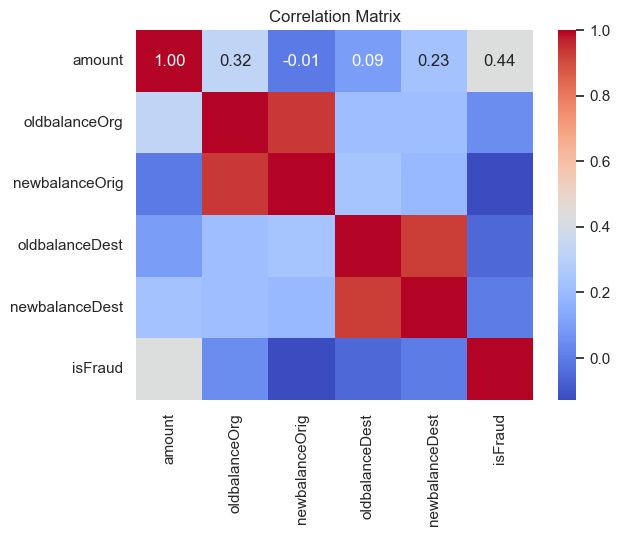

In [61]:
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [62]:
zero_after_transfer= df[
    (df["oldbalanceOrg"] > 0) & 
    (df["newbalanceOrig"] == 0) & 
    (df["type"].isin(["TRANSFER","CASH_OUT"]))
    ]

In [63]:
len(zero_after_transfer)

1791

In [64]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,log_amount,amount_winsor,balanceDiffOrig,balanceDiffDest
0,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,5.204007,187.48,181.0,0.0
1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,5.204007,187.48,181.0,-21182.0
2,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,7.939872,2806.00,2806.0,0.0
3,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,7.939872,2806.00,2806.0,-26202.0
4,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,9.909917,20128.00,20128.0,0.0


In [65]:
df["isFraud"].value_counts()

isFraud
0    10000
1     1142
Name: count, dtype: int64

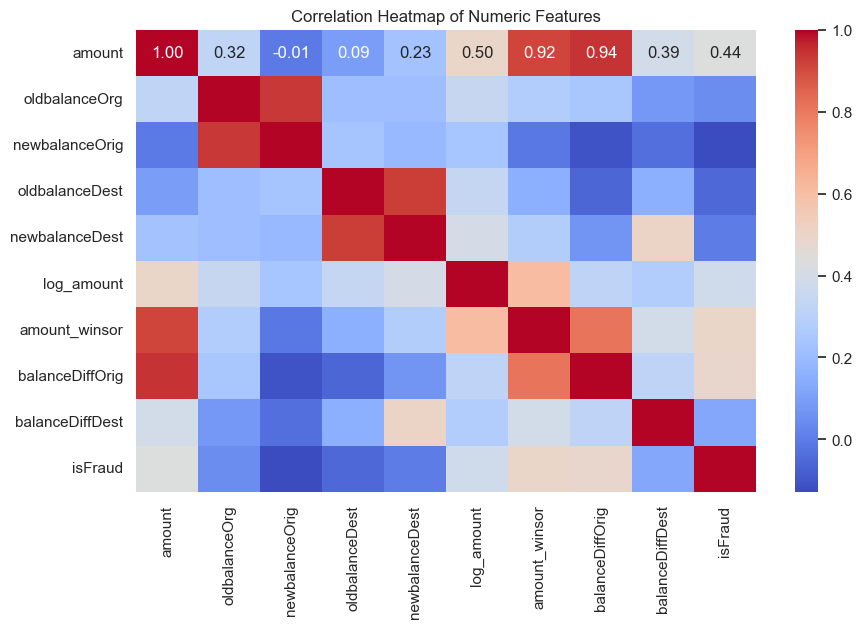

In [71]:
# Correlation heatmap (numeric features)
plt.figure(figsize=(10,6))
sns.heatmap(df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest",
                "log_amount","amount_winsor","balanceDiffOrig","balanceDiffDest","isFraud"]]
            .corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

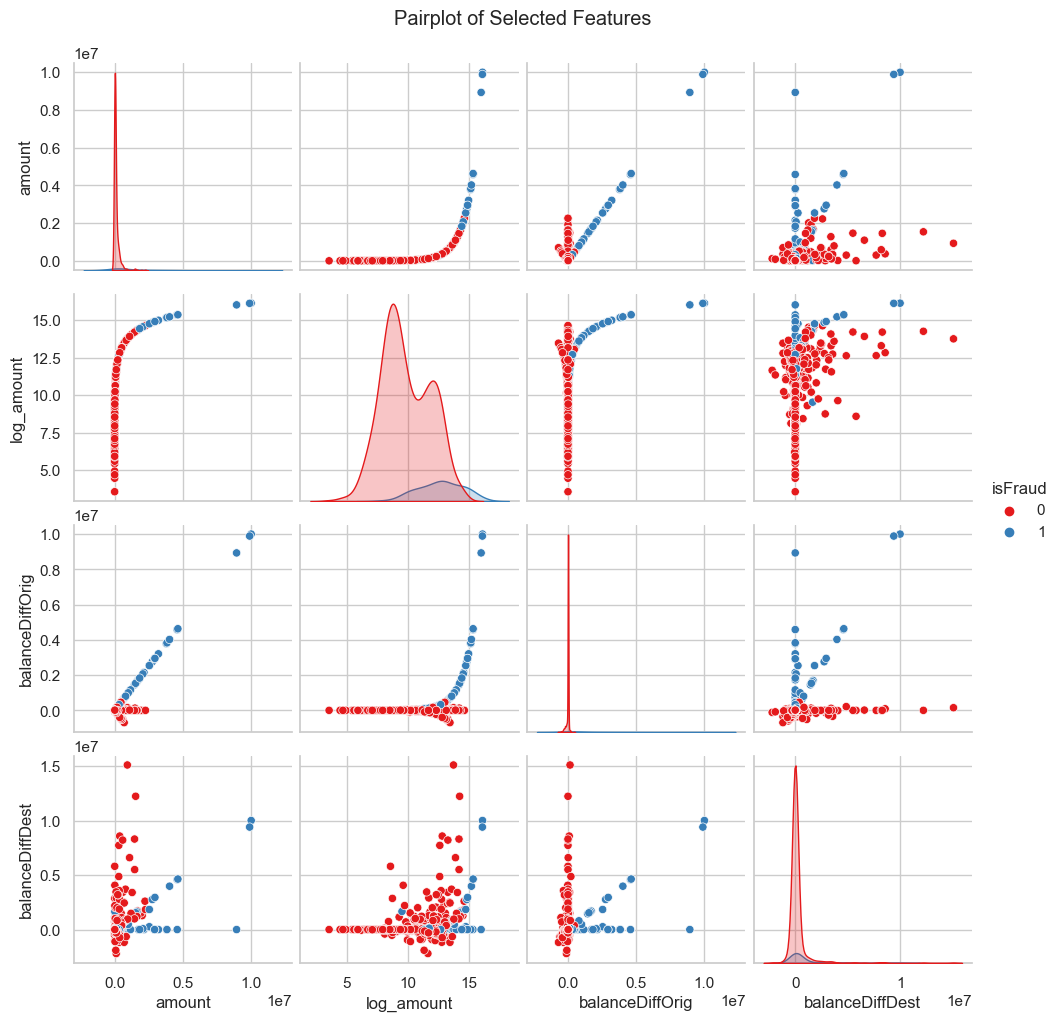

In [72]:
#  Pairplot of selected features
sns.pairplot(df.sample(1000), vars=["amount","log_amount","balanceDiffOrig","balanceDiffDest"], 
             hue="isFraud", diag_kind="kde", palette="Set1")
plt.suptitle("Pairplot of Selected Features ", y=1.02)
plt.show()

In [7]:
# ================================
# 4. Train-Test Split
# ================================
categorical = ["type"]
numeric = ["amount", "oldbalanceOrg", "newbalanceOrig", 
           "oldbalanceDest", "newbalanceDest", 
           "log_amount", "amount_winsor"]

y = df["isFraud"]
X = df.drop("isFraud", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


###  Data Preprocessing  

To prepare the dataset for machine learning models:  
- **Numeric Features** → standardized using `StandardScaler` to normalize scales.  
- **Categorical Features** → transaction `type` encoded using `OneHotEncoder` (dropping the first category to avoid dummy variable trap).  
- **ColumnTransformer** → combines both numeric scaling and categorical encoding into a single preprocessing step.  


In [8]:
# ================================
# 5. Preprocessing
# ================================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder="drop"
)


###  Handling Class Imbalance with SMOTE  

Fraudulent transactions are much rarer than normal ones, leading to class imbalance.  
To address this:  
- Applied preprocessing (`scaling` + `encoding`) to train and test sets.  
- Used **SMOTE (Synthetic Minority Over-sampling Technique)** on the training set to generate synthetic fraud samples, balancing the dataset.  
- The test set remains untouched to ensure fair evaluation on real-world distribution.  


In [9]:
# ================================
# 6. Apply SMOTE (after splitting)
# ================================
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_preprocessed, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())

Before SMOTE: isFraud
0    7000
1     799
Name: count, dtype: int64
After SMOTE: isFraud
0    7000
1    7000
Name: count, dtype: int64


###  Model Training & Performance Evaluation  

We trained and evaluated multiple machine learning models on the SMOTE-balanced dataset:  

- **Logistic Regression** → Linear baseline classifier, interpretable and efficient.  
- **Random Forest** → Ensemble of decision trees, robust to noise and capable of capturing non-linear relationships.  
- **Gradient Boosting** → Sequential tree-based model that corrects errors from previous trees, effective for structured data.  
- **Support Vector Machine (SVM)** → Finds an optimal decision boundary with kernel trick, useful for complex boundaries.  
- **K-Nearest Neighbors (KNN)** → Instance-based learning method relying on proximity in feature space.  
- **Naive Bayes** → Probabilistic classifier based on Bayes’ theorem, assuming feature independence.  
- **AdaBoost** → Boosting algorithm combining weak learners (shallow decision trees) into a strong classifier.  

**Evaluation Metrics**:  
- **Confusion Matrix** → Breakdown of true positives, false positives, true negatives, and false negatives.  
- **Classification Report** → Precision, Recall, F1-Score for both fraud and non-fraud classes.  
- **ROC-AUC Score** → Measures model’s ability to discriminate between fraud and non-fraud.  
- **Accuracy** → Overall percentage of correctly classified transactions.  

This evaluation helps compare models not just by accuracy but also by their ability to detect fraud (high recall) while minimizing false alarms.  


In [22]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_bal, y_train_bal)

y_pred_lr = log_reg.predict(X_test_preprocessed)
y_proba_lr = log_reg.predict_proba(X_test_preprocessed)[:, 1]

print("Logistic Regression")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_lr))
print("Accuracy:", log_reg.score(X_test_preprocessed, y_test) * 100, "%")


Logistic Regression
[[2689  311]
 [   5  338]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      3000
           1       0.52      0.99      0.68       343

    accuracy                           0.91      3343
   macro avg       0.76      0.94      0.81      3343
weighted avg       0.95      0.91      0.92      3343

ROC-AUC Score: 0.991491739552964
Accuracy: 90.54741250373915 %


In [23]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=50, max_depth=5, class_weight="balanced", random_state=42
)
rf.fit(X_train_bal, y_train_bal)

y_pred_rf = rf.predict(X_test_preprocessed)
y_proba_rf = rf.predict_proba(X_test_preprocessed)[:, 1]

print("Random Forest")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_rf))
print("Accuracy:", rf.score(X_test_preprocessed, y_test) * 100, "%")


Random Forest
[[2900  100]
 [  12  331]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3000
           1       0.77      0.97      0.86       343

    accuracy                           0.97      3343
   macro avg       0.88      0.97      0.92      3343
weighted avg       0.97      0.97      0.97      3343

ROC-AUC Score: 0.9967998056365402
Accuracy: 96.64971582411009 %


In [24]:
# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42
)
gb.fit(X_train_bal, y_train_bal)

y_pred_gb = gb.predict(X_test_preprocessed)
y_proba_gb = gb.predict_proba(X_test_preprocessed)[:, 1]

print("Gradient Boosting")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_gb))
print("Accuracy:", gb.score(X_test_preprocessed, y_test) * 100, "%")


Gradient Boosting
[[2916   84]
 [  10  333]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3000
           1       0.80      0.97      0.88       343

    accuracy                           0.97      3343
   macro avg       0.90      0.97      0.93      3343
weighted avg       0.98      0.97      0.97      3343

ROC-AUC Score: 0.9940447035957242
Accuracy: 97.1881543523781 %


In [25]:
# SVM
svm = SVC(probability=True, class_weight="balanced", random_state=42, kernel="rbf")
svm.fit(X_train_bal, y_train_bal)

y_pred_svm = svm.predict(X_test_preprocessed)
y_proba_svm = svm.predict_proba(X_test_preprocessed)[:, 1]

print("SVM")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_svm))
print("Accuracy:", svm.score(X_test_preprocessed, y_test) * 100, "%")


SVM
[[2582  418]
 [   4  339]]
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3000
           1       0.45      0.99      0.62       343

    accuracy                           0.87      3343
   macro avg       0.72      0.92      0.77      3343
weighted avg       0.94      0.87      0.89      3343

ROC-AUC Score: 0.9830855199222546
Accuracy: 87.37660783727192 %


In [26]:
# KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_bal, y_train_bal)

y_pred_knn = knn.predict(X_test_preprocessed)
y_proba_knn = knn.predict_proba(X_test_preprocessed)[:, 1]

print("KNN")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_knn))
print("Accuracy:", knn.score(X_test_preprocessed, y_test) * 100, "%")


KNN
[[2800  200]
 [  10  333]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3000
           1       0.62      0.97      0.76       343

    accuracy                           0.94      3343
   macro avg       0.81      0.95      0.86      3343
weighted avg       0.96      0.94      0.94      3343

ROC-AUC Score: 0.9852011661807581
Accuracy: 93.7182171702064 %


In [27]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_bal, y_train_bal)

y_pred_nb = nb.predict(X_test_preprocessed)
y_proba_nb = nb.predict_proba(X_test_preprocessed)[:, 1]

print("Naive Bayes")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_nb))
print("Accuracy:", nb.score(X_test_preprocessed, y_test) * 100, "%")


Naive Bayes
[[2249  751]
 [   1  342]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      3000
           1       0.31      1.00      0.48       343

    accuracy                           0.78      3343
   macro avg       0.66      0.87      0.67      3343
weighted avg       0.93      0.78      0.82      3343

ROC-AUC Score: 0.9350864917395529
Accuracy: 77.50523481902482 %


In [28]:
# AdaBoost
weak_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
ada = AdaBoostClassifier(
    base_estimator=weak_tree, n_estimators=50, learning_rate=0.5, random_state=42
)
ada.fit(X_train_bal, y_train_bal)

y_pred_ada = ada.predict(X_test_preprocessed)
y_proba_ada = ada.predict_proba(X_test_preprocessed)[:, 1]

print("AdaBoost")
print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_ada))
print("Accuracy:", ada.score(X_test_preprocessed, y_test) * 100, "%")


/Users/Prathyusha/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost
[[2921   79]
 [   8  335]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3000
           1       0.81      0.98      0.89       343

    accuracy                           0.97      3343
   macro avg       0.90      0.98      0.94      3343
weighted avg       0.98      0.97      0.98      3343

ROC-AUC Score: 0.9968377065111759
Accuracy: 97.39754711337122 %


### 📈 Model Comparison with Key Metrics & Financial Impact  

To identify the best fraud detection model, we compare all classifiers using both **performance metrics** and **financial impact**:  

- **Performance Metrics**:  
  - **Accuracy** → Overall percentage of correct predictions.  
  - **Precision** → How many predicted frauds were actually fraud.  
  - **Recall** → How many actual frauds were correctly detected (critical for fraud detection).  
  - **F1-Score** → Balance between precision and recall.  
  - **ROC-AUC** → Model’s ability to distinguish between fraud and non-fraud.  

- **Financial Impact**:  
  - **True Positives (TP)** → Fraud correctly detected → *saves money* (`loss_per_fraud`).  
  - **False Positives (FP)** → Normal transaction flagged as fraud → *investigation cost*.  
  - **Net Profit** = (TP × Saved Loss) – (FP × Investigation Cost).  

Finally, models are **ranked and sorted** by:  
1. **Net Profit** (business value),  
2. **Recall** (ability to catch fraud),  
3. **ROC-AUC** (overall discrimination ability).  

The top-ranked model is selected as the **best fraud detection model**.  


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# ----------------------------------
# Compare models with key metrics
# ----------------------------------
loss_per_fraud = 1000    # money saved if fraud detected
investigation_cost = 50  # cost of false positive investigation

summary = []

for name, (y_pred, y_proba) in {
    "Logistic Regression": (y_pred_lr, y_proba_lr),
    "Random Forest": (y_pred_rf, y_proba_rf),
    "Gradient Boosting": (y_pred_gb, y_proba_gb),
    "SVM": (y_pred_svm, y_proba_svm),
    "KNN": (y_pred_knn, y_proba_knn),
    "Naive Bayes": (y_pred_nb, y_proba_nb),
    "AdaBoost": (y_pred_ada, y_proba_ada),
}.items():
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    TP = ((y_test == 1) & (y_pred == 1)).sum()
    FP = ((y_test == 0) & (y_pred == 1)).sum()
    
    prevented_loss = TP * loss_per_fraud
    investigation = FP * investigation_cost
    net_profit = prevented_loss - investigation
    
    summary.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": roc,
        "Net Profit": net_profit
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary)

# Sort by chosen metrics (Net Profit → Recall → ROC-AUC)
best_model = summary_df.sort_values(by=["Net Profit","Recall","ROC-AUC"], ascending=False).iloc[0]

print("Model Comparison:\n", summary_df)
print("\nBest Model Selected:")
print(best_model)


Model Comparison:
                  Model  Accuracy  Precision    Recall        F1   ROC-AUC  \
0  Logistic Regression  0.905474   0.520801  0.985423  0.681452  0.991492   
1        Random Forest  0.966497   0.767981  0.965015  0.855297  0.996800   
2    Gradient Boosting  0.971882   0.798561  0.970845  0.876316  0.994045   
3                  SVM  0.873766   0.447820  0.988338  0.616364  0.983086   
4                  KNN  0.937182   0.624765  0.970845  0.760274  0.985201   
5          Naive Bayes  0.775052   0.312900  0.997085  0.476323  0.935086   
6             AdaBoost  0.973975   0.809179  0.976676  0.885073  0.996838   

   Net Profit  
0      322450  
1      326000  
2      328800  
3      318100  
4      323000  
5      304450  
6      331050  

Best Model Selected:
Model         AdaBoost
Accuracy      0.973975
Precision     0.809179
Recall        0.976676
F1            0.885073
ROC-AUC       0.996838
Net Profit      331050
Name: 6, dtype: object


###  Financial Impact Analysis  

Beyond accuracy, it is essential to measure how fraud detection models impact business profit.  

We calculate **net profit** for each model using:  

- **True Positives (TP)** → correctly detected frauds → save money.  
- **False Positives (FP)** → normal transactions incorrectly flagged as fraud → investigation cost.  
- **Prevented Loss** = `TP × Loss per Fraud`.  
- **Investigation Cost** = `FP × Cost per Investigation`.  
- **Net Profit** = `Prevented Loss – Investigation Cost`.  

Finally, all models are compared and ranked by **Net Profit** to identify the most financially beneficial model.  


In [31]:
import pandas as pd

# ------------------------------
# Financial Impact Analysis
# ------------------------------
loss_per_fraud = 1000    # Money saved if fraud detected
investigation_cost = 50  # Cost to investigate a false positive

# Collect predictions from all models
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "SVM": y_pred_svm,
    "KNN": y_pred_knn,
    "Naive Bayes": y_pred_nb,
    "AdaBoost": y_pred_ada
}

rows = []

for name, yp in models.items():
    TP = ((y_test == 1) & (yp == 1)).sum()
    FP = ((y_test == 0) & (yp == 1)).sum()
    
    prevented_loss = TP * loss_per_fraud
    investigation = FP * investigation_cost
    net_profit = prevented_loss - investigation
    
    rows.append({
        "Model": name,
        "TP": TP,
        "FP": FP,
        "Prevented Loss": prevented_loss,
        "Investigation Cost": investigation,
        "Net Profit": net_profit
    })

# Create DataFrame
financial_df = pd.DataFrame(rows)

# Sort by Net Profit descending
financial_df = financial_df.sort_values(by="Net Profit", ascending=False).reset_index(drop=True)
print("\nFinancial Impact Analysis:\n")
print(financial_df)



Financial Impact Analysis:

                 Model   TP   FP  Prevented Loss  Investigation Cost  \
0             AdaBoost  335   79          335000                3950   
1    Gradient Boosting  333   84          333000                4200   
2        Random Forest  331  100          331000                5000   
3                  KNN  333  200          333000               10000   
4  Logistic Regression  338  311          338000               15550   
5                  SVM  339  418          339000               20900   
6          Naive Bayes  342  751          342000               37550   

   Net Profit  
0      331050  
1      328800  
2      326000  
3      323000  
4      322450  
5      318100  
6      304450  


###  Visualization of Financial Impact  

To better understand the **business performance** of each fraud detection model, we use three types of plots:  

1. **Horizontal Bar Chart – Net Profit**  
   - Shows the total net profit for each model.  
   - Models are sorted by profit, making it easy to spot the best performer.  
   - Labels on bars indicate exact profit values.  

2. **Stacked Bar Chart – True Positives vs False Positives**  
   - Green bars represent correctly detected fraud cases (TP).  
   - Red stacked bars represent false alarms (FP).  
   - Helps visualize the trade-off between fraud detection and unnecessary investigations.  

3. **Heatmap – Model Metrics**  
   - Compares key metrics (**TP, FP, Net Profit**) across all models.  
   - Net Profit is scaled to thousands for easier interpretation.  
   - Color intensity highlights the best and worst values.  

These visualizations provide a clear picture of both **financial gain** and **detection effectiveness**, helping in the selection of the most profitable fraud detection model.  


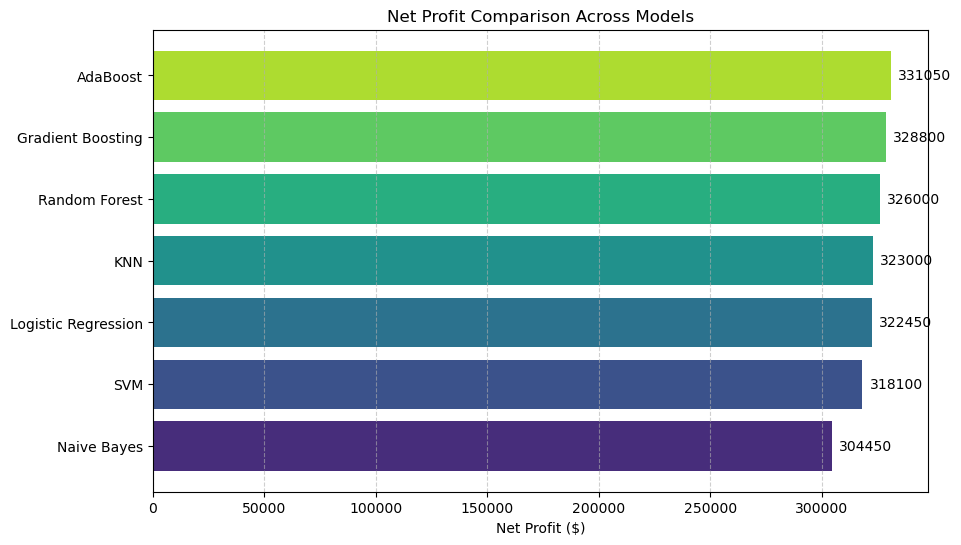

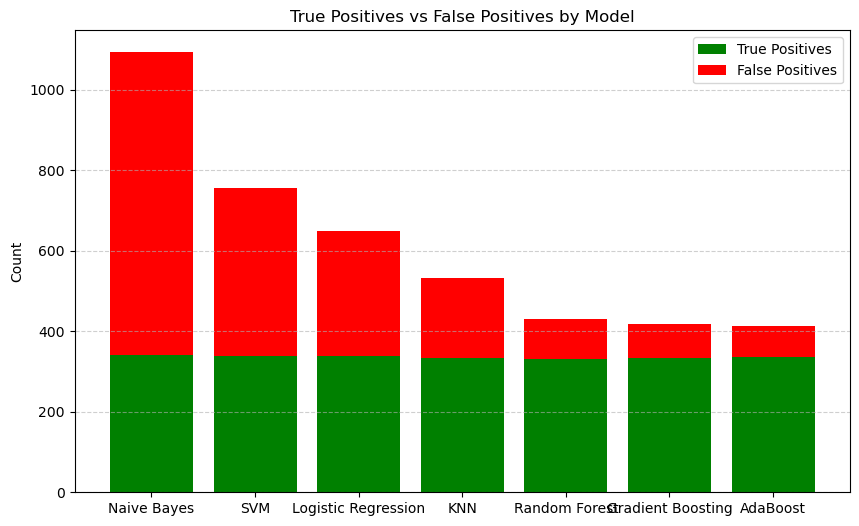

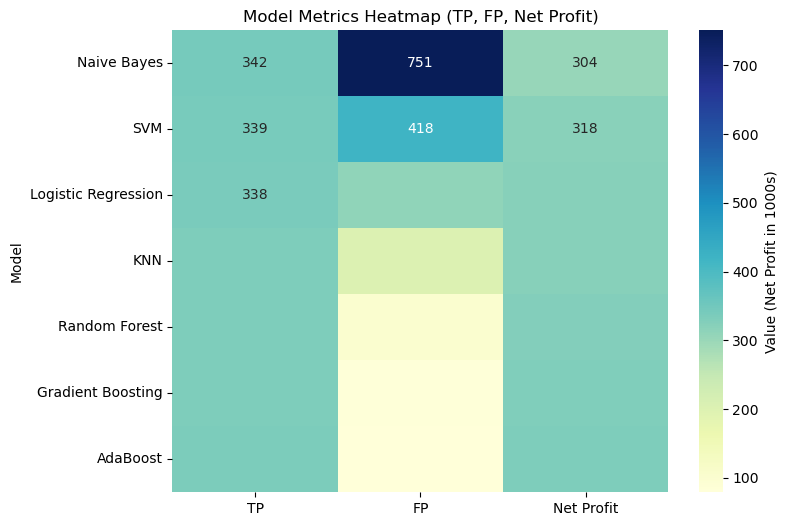

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 1. Sort DataFrame by Net Profit for plotting
# ------------------------------------------------
financial_df = financial_df.sort_values(by="Net Profit", ascending=True)

# ------------------------------------------------
# 2. Horizontal Bar Chart: Net Profit
# ------------------------------------------------
plt.figure(figsize=(10,6))
colors = sns.color_palette("viridis", len(financial_df))
plt.barh(financial_df["Model"], financial_df["Net Profit"], color=colors)
plt.xlabel("Net Profit ($)")
plt.title("Net Profit Comparison Across Models")

# Add labels on bars
for index, value in enumerate(financial_df["Net Profit"]):
    plt.text(value + (0.01 * max(financial_df["Net Profit"])), index, 
             f'{value}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------
# 3. Stacked Bar Chart: TP vs FP
# ------------------------------------------------
plt.figure(figsize=(10,6))
plt.bar(financial_df["Model"], financial_df["TP"], label='True Positives', color='green')
plt.bar(financial_df["Model"], financial_df["FP"], 
        bottom=financial_df["TP"], label='False Positives', color='red')
plt.ylabel("Count")
plt.title("True Positives vs False Positives by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# ------------------------------------------------
# 4. Heatmap of Metrics
# ------------------------------------------------
metrics_df = financial_df.set_index("Model")[["TP","FP","Net Profit"]].copy()

# Scale Net Profit for readability (in thousands)
metrics_df_scaled = metrics_df.copy()
metrics_df_scaled["Net Profit"] = metrics_df_scaled["Net Profit"] / 1000  

plt.figure(figsize=(8,6))
sns.heatmap(metrics_df_scaled, annot=True, fmt=".0f", cmap="YlGnBu", 
            cbar_kws={'label': 'Value (Net Profit in 1000s)'})
plt.title("Model Metrics Heatmap (TP, FP, Net Profit)")
plt.show()
